In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # 导入ARIMA模型的库
from scipy.optimize import curve_fit
from scipy import optimize
plt.rcParams["font.family"]="STSong"
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# 读取附件数据
df1 = pd.read_excel('附件1.xlsx')
df2 = pd.read_excel('附件2.xlsx')
df3 = pd.read_excel('附件3.xlsx')
df4 = pd.read_excel('附件4.xlsx')
df2 = df2.query('销售类型 == "销售"') # 仅保留销售类型为销售的

In [3]:
# 按单品分组，计算日均销售单价、日均销量、日均销售额
df2['销售日期'] = pd.to_datetime(df2['销售日期'])
df2['月份'] = df2['销售日期'].dt.month
df2['年份'] = df2['销售日期'].dt.year
df2['日'] = df2['销售日期'].dt.day  # 添加了日这一列
df2 = df2.merge(df1, on='单品编码', how='left')
df2['销售额'] = df2['销量(千克)'] * df2['销售单价(元/千克)']
grouped_df2 = df2.groupby(['单品编码', '年份', '月份', '日']).agg(
    {'销售额': 'sum', '销量(千克)': 'sum', '销售单价(元/千克)': 'mean'})  # 按日分组
grouped_df2.rename(columns={'销售单价(元/千克)': '日均销售单价', '销量(千克)': '日均销量'}, inplace=True)
grouped_df2 = grouped_df2.reset_index()

# 按日计算日均批发价格
df3['销售日期'] = pd.to_datetime(df3['销售日期'])
df3['月份'] = df3['销售日期'].dt.month
df3['年份'] = df3['销售日期'].dt.year
df3['日'] = df3['销售日期'].dt.day  # 添加了日这一列
grouped_df3 = df3.groupby(['单品编码', '年份', '月份', '日']).agg({'批发价格(元/千克)': 'mean'})  # 按日分组
grouped_df3.rename(columns={'批发价格(元/千克)': '日均批发价格'}, inplace=True)
grouped_df3 = grouped_df3.reset_index()

# 合并数据，计算日均成本和日均利润
merged_df = grouped_df2.merge(grouped_df3, on=['单品编码', '年份', '月份', '日'], how='left')
merged_df = merged_df.merge(df4, on='单品编码', how='left')
merged_df['日均成本'] = merged_df['日均销量'] * (1 + merged_df['损耗率(%)'] / 100) * merged_df['日均批发价格']
merged_df['日均利润'] = merged_df['销售额'] - merged_df['日均成本']

# 按蔬菜品类汇总，得到各蔬菜品类的日均销量、日均销售额、日均成本和日均利润
merged_df = merged_df.merge(df1[['单品编码', '分类名称']], on='单品编码', how='left')
grouped_merged_df = merged_df.groupby(['分类名称', '年份', '月份', '日']).agg({'日均销量': 'sum', '销售额': 'sum','日均成本': 'sum','日均利润': 'sum','日均批发价格': 'mean'})
grouped_merged_df = grouped_merged_df.reset_index()

花叶类的二维高斯函数为：z = exp(-((x-6.92)**2 / (2*212.78**2) + (y-23.76)**2 / (2*1464.86**2)))
食用菌的二维高斯函数为：z = exp(-((x-12.31)**2 / (2*454.05**2) + (y-22.40)**2 / (2*2070.11**2)))
辣椒类的二维高斯函数为：z = exp(-((x-11.53)**2 / (2*446.08**2) + (y-28.83)**2 / (2*2001.88**2)))
茄类的二维高斯函数为：z = exp(-((x-9.72)**2 / (2*228.96**2) + (y-15.40)**2 / (2*831.20**2)))
花菜类的二维高斯函数为：z = exp(-((x-9.79)**2 / (2*274.62**2) + (y-31.98)**2 / (2*2324.86**2)))
水生根茎类的二维高斯函数为：z = exp(-((x-10.62)**2 / (2*334.67**2) + (y-34.01)**2 / (2*2228.02**2)))


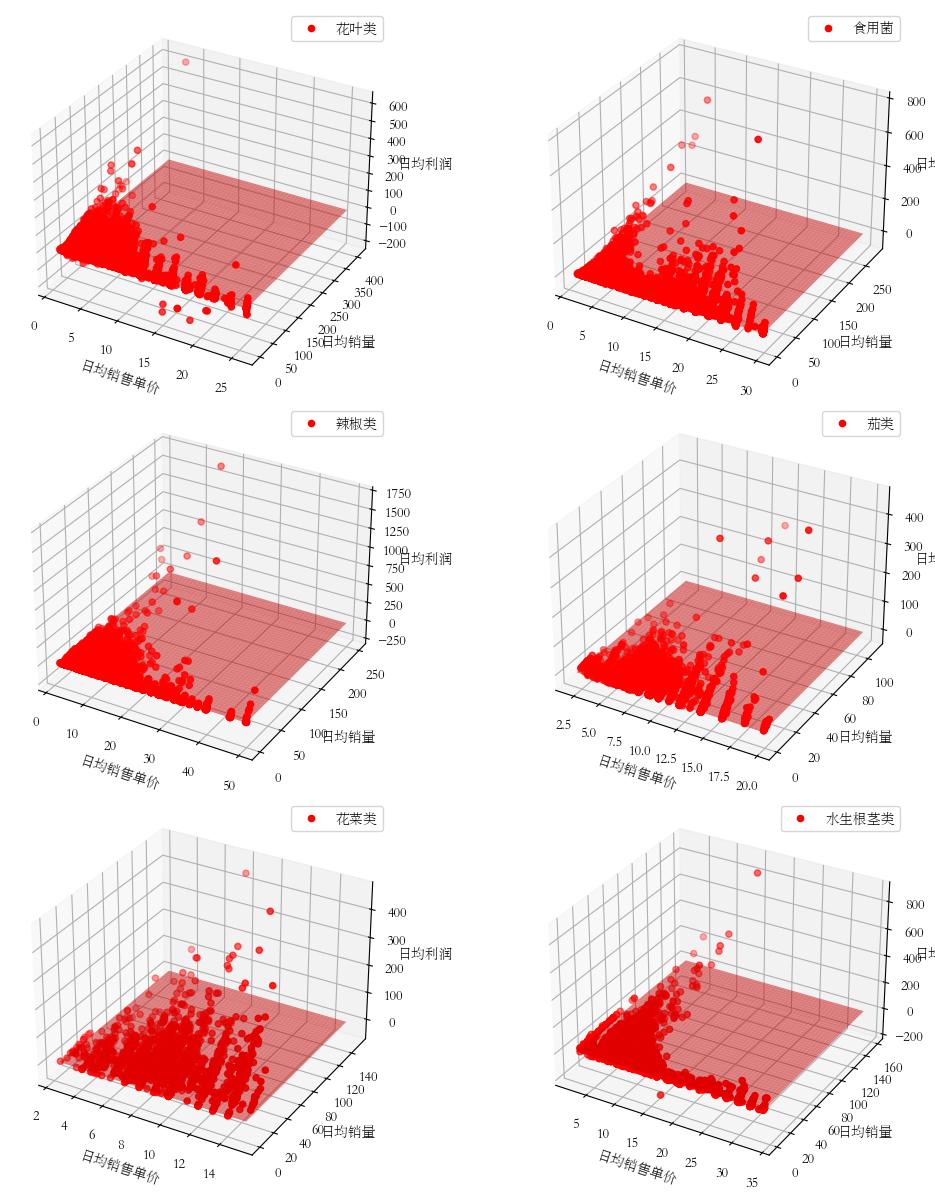

In [4]:
# 定义二维高斯函数的形式
def gaussian(data, mu_x, mu_y, sigma_x, sigma_y):
    # 从data中提取X和y
    X, y = data[:, 0], data[:, 1]
    # 计算每个数据点对应的高斯函数值
    z = np.exp(-((X - mu_x) ** 2 / (2 * sigma_x ** 2) + (y - mu_y) ** 2 / (2 * sigma_y ** 2)))
    # 返回一个长度为M的数组
    return z

# 使用子图的方式，绘制日均销量-日均销售单价-日均利润的关系图，用二维高斯函数拟合曲面
fig = plt.figure(figsize=(12, 12))
for i, cat in enumerate(merged_df['分类名称'].unique()):
    ax = fig.add_subplot(3, 2, i + 1, projection='3d')
    sub_df = merged_df[merged_df['分类名称'] == cat]
    # 根据日均销售单价的分布，去掉异常值
    sub_df = sub_df[sub_df['日均销售单价'] <= sub_df['日均销售单价'].quantile(0.99)]
    # 使用红色的点来绘制散点图
    ax.scatter(sub_df['日均销售单价'], sub_df['日均销量'], sub_df['日均利润'], label=cat, color='red')

    # 拟合参数
    X = sub_df['日均销售单价']
    y = sub_df['日均销量']
    z = sub_df['日均利润']

    # 拟合参数
    data = np.column_stack((X, y))  # 将X和y合并成一个数组
    # 估计参数的初始值，可以根据实际情况调整
    mu_x_est = X.mean()
    mu_y_est = y.mean()
    sigma_x_est = X.std()
    sigma_y_est = y.std()
    popt, pcov = curve_fit(gaussian, data, z, p0=[mu_x_est, mu_y_est, sigma_x_est, sigma_y_est],maxfev=10000)

    # 使用拟合参数来绘制曲面，使用红色的线
    x_new = np.linspace(X.min(), X.max(), 100)
    y_new = np.linspace(y.min(), y.max(), 100)
    x_new, y_new = np.meshgrid(x_new, y_new)
    data_new = np.column_stack((x_new.ravel(), y_new.ravel()))
    z_new = gaussian(data_new, *popt)

    # 使用红色的线来绘制曲面
    ax.plot_surface(x_new, y_new, z_new.reshape(x_new.shape), color='red', alpha=0.5)

    # 输出二维高斯函数的方程
    print(f'{cat}的二维高斯函数为：z = exp(-((x-{popt[0]:.2f})**2 / (2*{popt[2]:.2f}**2) + (y-{popt[1]:.2f})**2 / (2*{popt[3]:.2f}**2)))')


    ax.set_xlabel('日均销售单价')
    ax.set_ylabel('日均销量')
    ax.set_zlabel('日均利润')
    ax.legend()
plt.tight_layout()
plt.savefig('日均销量-日均销售单价-日均利润关系图.png', dpi=600)

In [5]:
# 建立ARIMA模型，对每个品类的日均销量和日均批发价格进行预测，预测每个品类未来一周(2023 年 7 月 1-7 日)的日均销量和日均批发价格
predictions = []
prices = []
for cat in grouped_merged_df['分类名称'].unique():
    sub_df = grouped_merged_df[grouped_merged_df['分类名称'] == cat]
    sub_df = sub_df.copy() # 复制DataFrame，确保修改的是副本
    sub_df['销售日期'] = pd.to_datetime(sub_df['年份'].astype(str) + '-' + sub_df['月份'].astype(str) + '-' + sub_df['日'].astype(str))
    sub_df = sub_df.set_index('销售日期')  # 将销售日期设为索引
    y_sales = sub_df['日均销量']  # 取出日均销量作为时间序列数据
    y_prices = sub_df['日均批发价格']  # 取出日均批发价格作为时间序列数据

    # 使用ARIMA模型预测销量
    model_sales = ARIMA(y_sales, order=(4, 3, 4))  # 使用ARIMA模型，设置阶数为(4, 2, 4)
    model_fit_sales = model_sales.fit()
    pred_sales = model_fit_sales.get_forecast(steps=7)  # 预测未来7天的日均销量
    pred_ci_sales = pred_sales.conf_int()  # 得到销量的预测置信区间

    # 使用ARIMA模型预测批发价格
    model_prices = ARIMA(y_prices, order=(5, 3, 5))  # 使用ARIMA模型，设置阶数为(5, 2, 5)
    model_fit_prices = model_prices.fit()
    pred_prices = model_fit_prices.get_forecast(steps=7)  # 预测未来7天的日均批发价格
    pred_ci_prices = pred_prices.conf_int()  # 得到批发价格的预测置信区间

    predictions.append(
        [cat, pred_sales.predicted_mean, pred_ci_sales, pred_prices.predicted_mean, pred_ci_prices])  # 将预测结果和置信区间保存为列表

In [6]:
# 定义一个函数，将p_pred代入进去，得到z值
def gaussian_z(x, mu_x, mu_y, sigma_x, sigma_y, p_pred):
    return  np.exp(-((x - mu_x) ** 2 / (2 * sigma_x ** 2) + (p_pred - mu_y) ** 2 / (2 * sigma_y ** 2)))

# 利用每个品类的日均单价和日均销量和日均利润的二维高斯函数，算出未来一周(2023 年 7 月 1-7 日)的单价，就是我们的定价
time_points = [0, 1, 2, 3, 4, 5, 6]  # 以示例时间点为准，您需要提供实际的时间点列表
for i, cat in enumerate(merged_df['分类名称'].unique()):
    sub_df = merged_df[merged_df['分类名称'] == cat]
    X = sub_df['日均销售单价']
    y = sub_df['日均销量']
    z = sub_df['日均利润']
    data = np.column_stack((X, y))  # 将X和y合并成一个数组
    # 估计参数的初始值，可以根据实际情况调整
    mu_x_est = X.mean()
    mu_y_est = y.mean()
    sigma_x_est = X.std()
    sigma_y_est = y.std()
    popt, pcov = curve_fit(gaussian, data, z, p0=[mu_x_est, mu_y_est, sigma_x_est, sigma_y_est], maxfev=10000)
    
    # 获取对应时间点的 q_pred
    for i, q_pred in enumerate(predictions[i][1]):
        # 定义利润函数，以单价 p 为自变量，将 q_pred 传递给 gaussian_z 函数
        def profit(p):
            return -gaussian_z(p, popt[0], popt[1], popt[2], popt[3], q_pred)  # 负号表示最大化利润
        p_pred = optimize.fminbound(profit, X.min(), X.max())  # 在单价的范围内求解最大化利润时的单价
        prices.append([cat, p_pred, time_points[i]])  # 将品类、p_pred 和时间点添加到 prices 列表中
# 将prices这个列表转化为dataframe
prices_df = pd.DataFrame(prices, columns=['分类名称', '预测单价', '日期'])
# 输出prices_df
print(prices_df)

     分类名称  预测单价  日期
0     花叶类  7.15   0
1     花叶类  7.15   1
2     花叶类  7.15   2
3     花叶类  7.15   3
4     花叶类  7.15   4
5     花叶类  7.15   5
6     花叶类  7.15   6
7     食用菌 12.47   0
8     食用菌 12.47   1
9     食用菌 12.47   2
10    食用菌 12.47   3
11    食用菌 12.47   4
12    食用菌 12.47   5
13    食用菌 12.47   6
14    辣椒类 12.63   0
15    辣椒类 12.63   1
16    辣椒类 12.63   2
17    辣椒类 12.63   3
18    辣椒类 12.63   4
19    辣椒类 12.63   5
20    辣椒类 12.63   6
21     茄类  9.74   0
22     茄类  9.74   1
23     茄类  9.74   2
24     茄类  9.74   3
25     茄类  9.74   4
26     茄类  9.74   5
27     茄类  9.74   6
28    花菜类  9.85   0
29    花菜类  9.85   1
30    花菜类  9.85   2
31    花菜类  9.85   3
32    花菜类  9.85   4
33    花菜类  9.85   5
34    花菜类  9.85   6
35  水生根茎类 10.83   0
36  水生根茎类 10.83   1
37  水生根茎类 10.83   2
38  水生根茎类 10.83   3
39  水生根茎类 10.83   4
40  水生根茎类 10.83   5
41  水生根茎类 10.83   6


In [7]:
# 计算补货总量，使用损耗率的加权平均值
replenishments = []
for i, cat in enumerate(merged_df['分类名称'].unique()):
    sub_df = merged_df[merged_df['分类名称'] == cat]
    q_pred = predictions[i][1]  # 取出预测的日均销量
    r_dict = dict(zip(sub_df['单品编码'], sub_df['损耗率(%)']))  # 创建一个字典，存储每个商品编码和对应的损耗率
    w_dict = dict(sub_df.groupby('单品编码')['日均销量'].sum() / sub_df['日均销量'].sum())  # 创建一个字典，存储每个商品编码和对应的销量占比
    r = sum([r_dict[k] * w_dict[k] for k in r_dict]) / 100  # 计算损耗率的加权平均值
    replenishment = q_pred * (1 + r)  # 计算补货量
    replenishments.append([cat, replenishment])

In [18]:
# 计算利润，利润等于预测的单价乘以预测的销量减去成本，成本等于预测的补货量乘以批发价格
profits = []
for i, cat in enumerate(merged_df['分类名称'].unique()):
    sub_df = merged_df[merged_df['分类名称'] == cat]
    pp_pred = predictions[i][3]
    pp_pred.reset_index(drop=True, inplace=True)
    q_pred = predictions[i][1]
    q_pred.reset_index(drop=True, inplace=True)
    replenishment = replenishments[i][1]
    replenishment.reset_index(drop=True, inplace=True)
    
    for j in range(0,7):
        p_pred = prices_df.loc[(prices_df['分类名称'] == cat) & (prices_df['日期'] == j), '预测单价'].values
        # 计算成本，使用对应品类对应天数的预测批发价格
        cost = replenishment[j] * pp_pred[j] # 假设每个品类的批发价格都不一样

        # 计算利润
        profit = (p_pred[0] * q_pred[j]) - cost
        profits.append([cat, profit,j])
# 将prices这个列表转化为dataframe
profits_df = pd.DataFrame(profits, columns=['分类名称', '利润', '日期'])
# 输出prices_df
print(profits_df)

     分类名称      利润  日期
0     花叶类 -124.69   0
1     花叶类 -126.27   1
2     花叶类 -122.83   2
3     花叶类 -125.88   3
4     花叶类 -122.51   4
5     花叶类 -122.68   5
6     花叶类 -123.33   6
7     食用菌 1160.95   0
8     食用菌 1174.62   1
9     食用菌 1195.91   2
10    食用菌 1149.94   3
11    食用菌 1150.04   4
12    食用菌 1172.44   5
13    食用菌 1147.32   6
14    辣椒类  108.52   0
15    辣椒类   97.85   1
16    辣椒类  107.12   2
17    辣椒类  107.04   3
18    辣椒类  102.81   4
19    辣椒类  110.06   5
20    辣椒类  103.09   6
21     茄类   97.14   0
22     茄类   86.07   1
23     茄类   75.15   2
24     茄类   84.35   3
25     茄类   82.96   4
26     茄类   78.70   5
27     茄类   74.55   6
28    花菜类  327.82   0
29    花菜类  335.83   1
30    花菜类  339.48   2
31    花菜类  332.59   3
32    花菜类  340.78   4
33    花菜类  328.59   5
34    花菜类  342.32   6
35  水生根茎类  249.04   0
36  水生根茎类  273.25   1
37  水生根茎类  254.65   2
38  水生根茎类  265.98   3
39  水生根茎类  273.28   4
40  水生根茎类  266.38   5
41  水生根茎类  279.70   6


In [20]:
# 保存结果为csv文件
predictions_df = pd.DataFrame(predictions, columns=['分类名称', '预测日均销量', '预测销量置信区间', '预测日均批发价格',
                                                    '预测批发价格置信区间'])
predictions_df.to_csv('Arima法预测结果.csv', index=False, encoding='utf_8_sig')
prices_df.to_csv('Arima法7天的最优单价.csv', index=False, encoding='utf_8_sig')
replenishments_df = pd.DataFrame(replenishments, columns=['分类名称', '补货量'])
replenishments_df.to_csv('Arima法7天的补货量.csv', index=False, encoding='utf_8_sig')
profits_df.to_csv('Arima法7天的预测利润.csv', index=False, encoding='utf_8_sig')

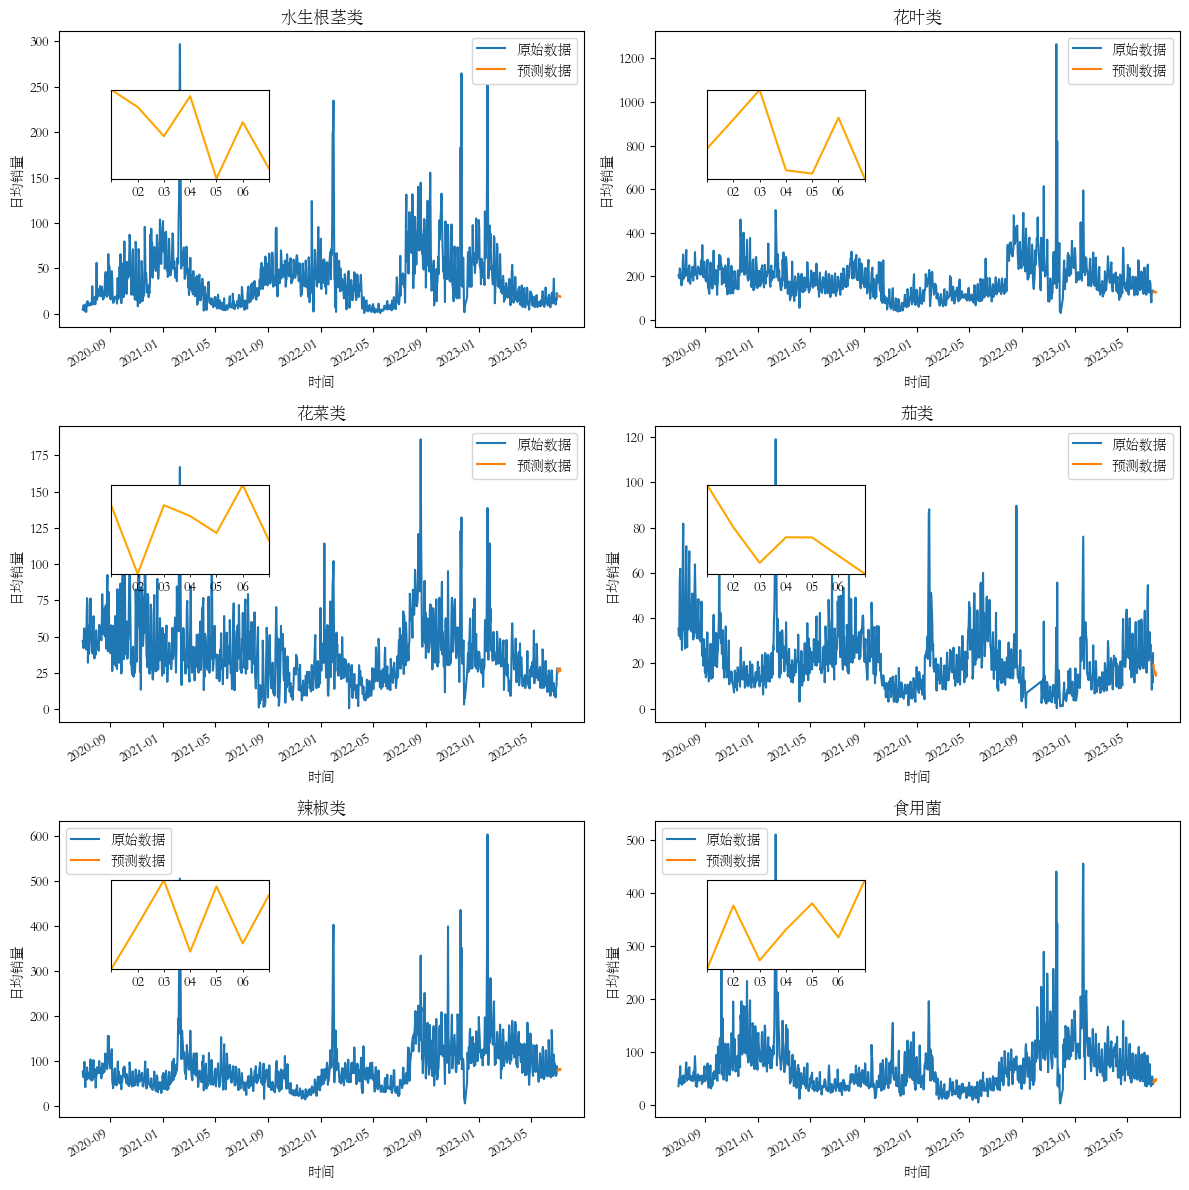

In [21]:
# 可视化预测结果和原始数据的对比
fig, axes = plt.subplots(3, 2, figsize=(12, 12)) # 使用子图的方式
for i, cat in enumerate(grouped_merged_df['分类名称'].unique()):
    ax = axes[i // 2, i % 2]
    sub_df = grouped_merged_df[grouped_merged_df['分类名称'] == cat]
    sub_df = sub_df.copy() # 复制DataFrame，确保修改的是副本
    sub_df['销售日期'] = pd.to_datetime(sub_df['年份'].astype(str) + '-' + sub_df['月份'].astype(str) + '-' + sub_df['日'].astype(str))
    sub_df = sub_df.set_index('销售日期')  # 将销售日期设为索引
    y = sub_df['日均销量'] # 取出日均销量作为时间序列数据
    q_pred = predictions[i][1] # 取出预测的日均销量
    q_pred.index = pd.date_range(start='2023-07-01', periods=len(q_pred)) # 将索引设置为日期范围
    y.plot(ax=ax, label='原始数据') # 画出原始数据的折线图
    q_pred.plot(ax=ax, label='预测数据') # 画出预测数据的折线图
    ax.set_xlabel('时间')
    ax.set_ylabel('日均销量')
    ax.set_title(cat)
    ax.legend()

    # 添加放大的子坐标轴
    axins = ax.inset_axes([0.1, 0.5, 0.3, 0.3])  # 调整位置和大小
    q_pred.plot(ax=axins, label='预测数据', color='orange')
    axins.set_xlim(pd.Timestamp('2023-07-01'), pd.Timestamp('2023-07-07'))
    axins.set_ylim(min(q_pred), max(q_pred))
    axins.set_xticks([])  # 隐藏x轴刻度
    axins.set_yticks([])  # 隐藏y轴刻度

plt.tight_layout()
plt.savefig('Arima预测.png', dpi=600)